Reproduction of the experiment from Fig 1

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cvxpy as cp

# Quantile Loss

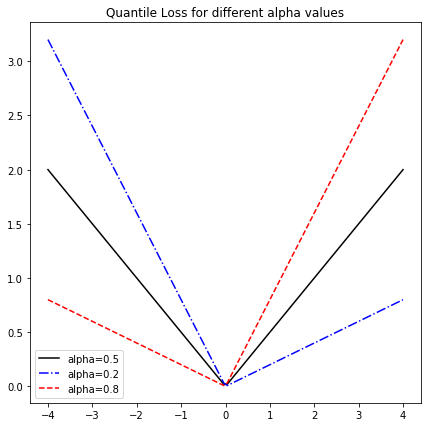

In [18]:
quantile_loss = lambda x, alpha=0.5: x*(alpha - (x<0))

plt.figure(figsize=(7,7))

x = np.linspace(-4,4,100)
plt.plot(x, quantile_loss(x), c="black", label="alpha=0.5")
plt.plot(x, quantile_loss(x,0.2), "b-.", label="alpha=0.2")
plt.plot(x, quantile_loss(x,0.8), "r--", label="alpha=0.8")

plt.title("Quantile Loss for different alpha values")

plt.legend()

plt.show()

# Generic Data

In [89]:
nsample = 40
sigma = np.sqrt(0.25)

X = 2*np.random.random(nsample) - 1
e = sigma*np.random.randn(nsample)
y = X + e

theoretical_quantile = lambda x,alpha=0.5,sigma=1: sigma*norm().ppf(alpha) + x

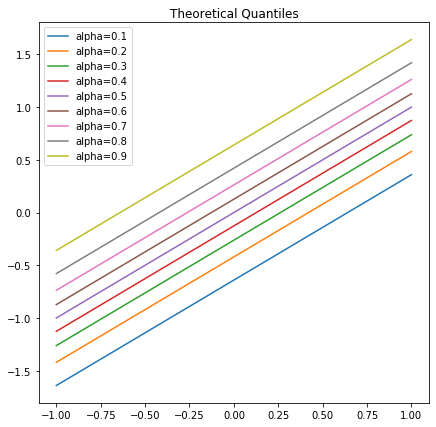

In [90]:
alpha_l = np.arange(0.1,1,0.1)
x = np.linspace(-1,1,100)

plt.figure(figsize=(7,7))

for alpha in alpha_l:
    plt.plot(x, theoretical_quantile(x,alpha,sigma), label="alpha={}".format(np.round(alpha,2)))

plt.title("Theoretical Quantiles")
plt.legend()
plt.show()

# Kernel Quantile Regression

In [91]:
gauss_kernel = lambda x,y,signa=1: np.exp(-np.sum((x-y)**2)/sigma**2)
K_left = lambda x, K, sigma: np.array([gauss_kernel(x,X[i]) for i in range(nsample)]) 

K = np.zeros((nsample,nsample))
for i in range(nsample):
    for j in range(nsample):
        K[i,j] = gauss_kernel(X[i],X[j],sigma)

alpha=0.5

# Generate a random non-trivial quadratic program.
m = 4*nsample
n = 4*nsample
p = nsample

np.random.seed(1)

P = np.zeros((n,n))
P[0:nsample,0:nsample] = K
P[0:nsample,nsample:2*nsample] = -K
P[nsample:2*nsample,0:nsample] = -K
P[nsample:2*nsample,nsample:2*nsample] = K
P = 2*P

q = np.zeros(4*nsample)
q[2*nsample:3*nsample] = alpha
q[3*nsample:4*nsample] = 1-alpha

G = -np.eye(n)

h = 0

A = np.hstack([K,-K,np.eye(nsample),-np.eye(nsample)])

b = y

# Define and solve the CVXPY problem.
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),
                 [G @ x <= h,
                  A @ x == b])
prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
#print("A solution x is")
#print(x.value)
#print("A dual solution corresponding to the inequality constraints is")
#print(prob.constraints[0].dual_value)


The optimal value is 7.497784300475964


In [92]:
w_opt = x.value[2*nsample:3*nsample] - x.value[3*nsample:4*nsample]
print(w_opt.shape)

(40,)


In [93]:
#K_left = lambda x, K, sigma: np.array([gauss_kernel(x,X[i]) for i in range(nsample)]) 
quantile_sol = lambda x,w: np.sum([w[i]*gauss_kernel(x,X[i]) for i in range(nsample)])

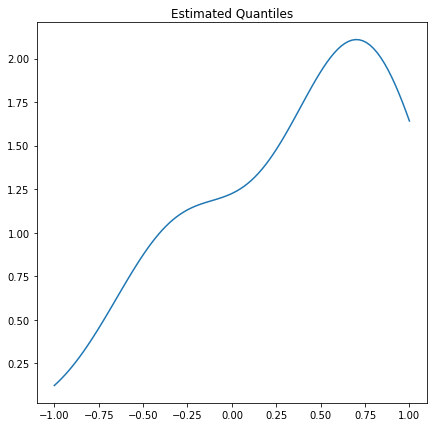

In [94]:
x = np.linspace(-1,1,100)

plt.figure(figsize=(7,7))

t = [quantile_sol(xi,w_opt) for xi in x]

plt.plot(x, t)

plt.title("Estimated Quantiles")
#plt.legend()
plt.show()

# Simultaneous Multiple Kernel Quantile Regression

array([[1.        , 0.86066537, 0.99938949, ..., 0.03074619, 0.59880437,
        0.37680521],
       [0.86066537, 1.        , 0.87676608, ..., 0.00623435, 0.29592138,
        0.15085166],
       [0.99938949, 0.87676608, 1.        , ..., 0.0280203 , 0.57762837,
        0.35862931],
       ...,
       [0.03074619, 0.00623435, 0.0280203 , ..., 1.        , 0.26653319,
        0.46254861],
       [0.59880437, 0.29592138, 0.57762837, ..., 0.26653319, 1.        ,
        0.92877444],
       [0.37680521, 0.15085166, 0.35862931, ..., 0.46254861, 0.92877444,
        1.        ]])